# Instalar dependencias

In [1]:
!pip install torch_geometric

# Cargar el dataset

In [2]:
import json
import torch
import os.path as osp
from torch_geometric.data import InMemoryDataset, download_url

class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/mnsESjBucKUKsEg/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['tournament.pt']

    @property
    def processed_file_names(self):
        return ['tournament.pt']

    @property
    def num_classes(self):
        return 3

    @property
    def num_features(self):
        return 500

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='tournament.pt')

    def process(self):
        data_list = [torch.load(osp.join(self.raw_dir, 'tournament.pt'))]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

    def create_test_json(self, model, file_path, device="cpu"):
        data = self[0]

        model = model.to(device)
        data = data.to(device)

        model.eval()
        out = model(data.x, data.edge_index)
        y_pred = out[data.test_mask].argmax(dim=1)
        nid = data.nid[data.test_mask]

        pred = {
            'nid': nid.detach().cpu().numpy().tolist(),
            'y': y_pred.detach().cpu().numpy().tolist()
        }

        with open(file_path, 'w') as f:
            json.dump(pred, f)


In [4]:
dataset = TournamentDataset("tournament")
data = dataset[0]

# Definir el modelo

## GRU skip connection layer

$ z_i^l = \text{GRU}(W_{\phi}^l \sum_{j \in \mathcal{N}(i)} z_j^{l-1}, z_i^{t-1}) $

* **MSG**: $m_u^l = W_\phi^lz^{l-1}_u $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = \text{GRU}(a_u^l, z_u^{l-1}) $

In [60]:
from torch_geometric.nn import MLP,MessagePassing
import torch
import torch.nn.functional as F
from torch import nn
import torch
from torch_geometric.nn import MessagePassing, MLP
from torch_geometric.nn import MLP
from torch.nn import Linear
    

class UpdateGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        """
        Custom GRU based on the given equations.
        
        Args:
            input_dim (int): Dimension of the input vector x.
            hidden_dim (int): Dimension of the hidden state h.
        """
        super(UpdateGRU, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Input-to-hidden weights and biases
        self.W_ir = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_iz = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_in = nn.Linear(input_dim, hidden_dim, bias=True)
        
        # Hidden-to-hidden weights and biases
        self.W_hr = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_hz = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_hn = nn.Linear(hidden_dim, hidden_dim, bias=True)
        
        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def reset_parameters(self):
        self.W_ir.reset_parameters()
        self.W_iz.reset_parameters()
        self.W_in.reset_parameters()
        self.W_hr.reset_parameters()
        self.W_hz.reset_parameters()
        self.W_hn.reset_parameters

    def forward(self, x_t, h_t_minus_1):
        """
        Forward pass for a single time step.
        
        Args:
            x_t (torch.Tensor): Input vector at time t, shape (batch_size, input_dim).
            h_t_minus_1 (torch.Tensor): Hidden state at time t-1, shape (batch_size, hidden_dim).
        
        Returns:
            h_t (torch.Tensor): Updated hidden state at time t, shape (batch_size, hidden_dim).
        """
        # Compute reset gate
        r_t = self.sigmoid(self.W_ir(x_t) + self.W_hr(h_t_minus_1))
        
        # Compute update gate
        z_t = self.sigmoid(self.W_iz(x_t) + self.W_hz(h_t_minus_1))
        
        # Compute candidate hidden state
        n_t = self.tanh(self.W_in(x_t) + r_t * self.W_hn(h_t_minus_1))
        
        # Compute new hidden state
        h_t = (1 - z_t) * n_t + z_t * h_t_minus_1
        
        return h_t
class GRUConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        """
        GRU convolutional net for graphs
        Args:
            in_channels (torch.Tensor): Size of input data.
            out_channels (torch.Tensor): Size of output data.
        """

        # Aggregate is the sum of the message
        super(GRUConv, self).__init__(aggr='sum') 

        self.W_phi = Linear(in_channels, out_channels, bias=True)
        self.gru = UpdateGRU(in_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_phi.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, x, edge_index):
        """
        Forward propagation
        Args:
            x (torch.Tensor): Input data.
            edge_index (torch.Tensor): Edges of the data.
        Return:
            Processed data.
        """
        return self.propagate(edge_index, x=x, central_node=x)
    
    def message(self, x_j):
        """
        Define the message
        Args:
            x_j (torch.Tensor): input data.
        Returns:
            Message of the conv net.
        """
        return self.W_phi(x_j)
    
    def update(self, aggr_out, central_node):
        """
        Define the update
        Args:
            aggr_out (torch.Tensor): Result of the aggregate step
            central_node (torch.Tensor): Central node
        Returns:
            Update of the conv net.
        """
        return self.gru(central_node, aggr_out)
class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()

        # GRU layer number 1
        self.conv1 = GRUConv(node_features, hidden_channels)
        
        # GRU layer number 2
        self.conv2 = GRUConv(hidden_channels, hidden_channels)
        
        # Classification net
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.mish(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.mish(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

model=GCN(dataset.num_node_features,hidden_channels=256,num_classes=dataset.num_classes)

# Entrenar el modelo

In [61]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam,AdamW
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
# for i in range(len(data.train_mask)):
#     data.train_mask[i]=True
best=0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)


for epoch in range(800):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
    score=f1_score(y, y_pred, average='micro')
    if score>=best:
        best=score
        checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
        torch.save(checkpoint, 'best_model.pth')


Epoch 0: Loss 1.0951130390167236
Epoch 20: Loss 0.8851660490036011
Epoch 40: Loss 0.658351480960846
Epoch 60: Loss 0.48218873143196106
Epoch 80: Loss 0.4176313281059265
Epoch 100: Loss 0.3817732036113739
Epoch 120: Loss 0.35172149538993835
Epoch 140: Loss 0.31891563534736633
Epoch 160: Loss 0.2857583463191986
Epoch 180: Loss 0.2598259449005127
Epoch 200: Loss 0.2354690283536911
Epoch 220: Loss 0.2165306955575943
Epoch 240: Loss 0.20194391906261444
Epoch 260: Loss 0.18799598515033722
Epoch 280: Loss 0.1759006381034851
Epoch 300: Loss 0.16929133236408234
Epoch 320: Loss 0.15875326097011566
Epoch 340: Loss 0.15095384418964386
Epoch 360: Loss 0.14259207248687744
Epoch 380: Loss 0.13780240714550018
Epoch 400: Loss 0.13444113731384277
Epoch 420: Loss 0.12704065442085266
Epoch 440: Loss 0.12159182876348495
Epoch 460: Loss 0.1151026040315628
Epoch 480: Loss 0.1120307669043541
Epoch 500: Loss 0.10973092913627625
Epoch 520: Loss 0.10366074740886688
Epoch 540: Loss 0.10290832817554474
Epoch 560: 

# Validación

/tmp/ipykernel_12175/3774835888.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(checkpoint_path)


F1 score: 0.8952112676056339


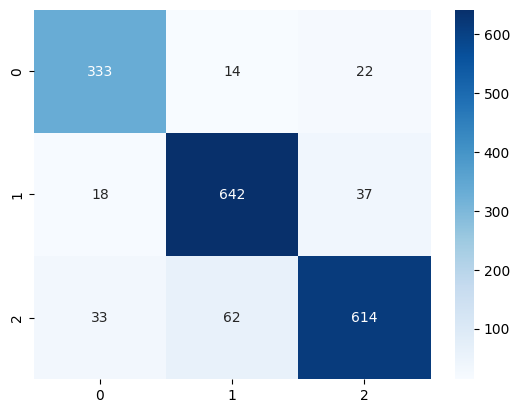

In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
checkpoint_path = "best_model.pth"
# checkpoint_path = "t5_checkpoint.pth"
checkpoint=torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
out = model(data.x, data.edge_index)
y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')
dataset.create_test_json(model, 'pred_labels.json', device=device)

# Generar solución para el torneo